In [2]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size

from utils.utils import *
sr = 16000


In [3]:
model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint a

4436.18310546875 MiB


In [4]:
prompt = "90s rock song with electric guitar and heavy drums."
duration = 30.0 

In [5]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

DEBUG DURATION CONVERSION:
Requested duration: 30.0s
Latent size (time frames): 768
Latent shape: [1, 8, 768, 16]
Expected frames per second in latent space: 25.60
Processing chunk 1/3
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.30it/s]


Processing chunk 2/3
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.27it/s]


Processing chunk 3/3
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.34it/s]



Diffusion time: 36.81s, peak mem: 4689.9 MiB, curr mem: 4445.5 MiB
Final latent shape: torch.Size([1, 8, 768, 16])
✅ Diffusion latent output is clean (no NaN/Inf)


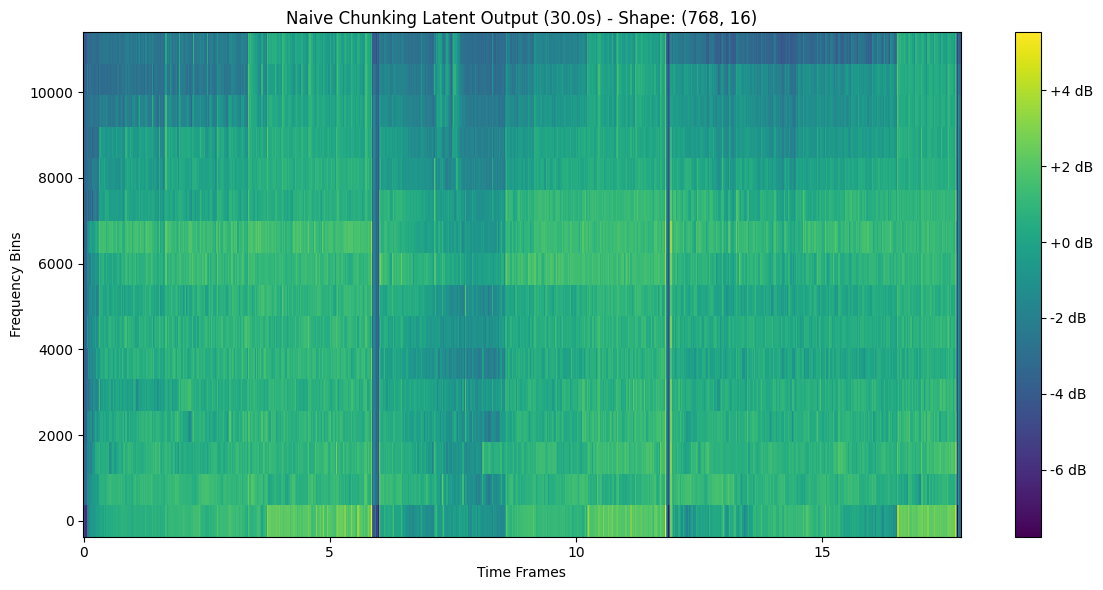

Latent stats - Min: -7.767, Max: 5.528, Mean: 0.075, Std: 1.268


In [6]:
# Run Naive Chunking Diffusion Loop
## Set parameters
ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0
chunk_frames = 256

# Scheduler and initial noise
sampler = DDIMSampler(model)
latent_size = duration_to_latent_t_size(duration)
shape = [1, model.channels, latent_size, model.latent_f_size]
z = torch.randn(shape).to(model.device)

# Debug duration conversion
print(f"DEBUG DURATION CONVERSION:")
print(f"Requested duration: {duration}s")
print(f"Latent size (time frames): {latent_size}")
print(f"Latent shape: {shape}")
print(f"Expected frames per second in latent space: {latent_size / duration:.2f}")

# Memory & timing
memory_before_diffusion = torch.cuda.memory_allocated() / (1024*1024)
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

# Process chunks without overlap
chunks = torch.split(z, chunk_frames, dim=2)
processed_chunks = []

with torch.no_grad():
    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1}/{len(chunks)}")
        processed_chunk = multidiffusion_sample_clean(
            sampler=sampler,
            shape=chunk.shape,
            conditioning=text_emb,
            unconditional_conditioning=unconditional_embedding,
            unconditional_guidance_scale=unconditional_guidance_scale,
            eta=ddim_eta,
            x_T=chunk,
            S=ddim_steps,
            chunk_frames=chunk.shape[2],
            overlap_frames=0  # No overlap
        )
        processed_chunks.append(processed_chunk)

# Concatenate processed chunks
samples = torch.cat(processed_chunks, dim=2)
torch.cuda.synchronize()

# Report performance
diffusion_time = time.time() - start_time
peak_mem = torch.cuda.max_memory_allocated() / (1024*1024)
curr_mem = torch.cuda.memory_allocated() / (1024*1024)
print(f"Diffusion time: {diffusion_time:.2f}s, peak mem: {peak_mem:.1f} MiB, curr mem: {curr_mem:.1f} MiB")

# Display final latent
print(f"Final latent shape: {samples.shape}")
check_for_nan_inf(samples, "Diffusion latent output")
plot_latent_spectrogram(samples, f"Naive Chunking Latent Output ({duration}s)")

VAE DECODER ISOLATED PEAK: 5718.7 MiB (cost: +1272.8 MiB)
VAE DECODER CURRENT MEMORY: 4445.9 MiB
VAE TIME: 0.1s

🔍 VAE DECODER OUTPUT ANALYSIS:
Mel spectrogram shape: torch.Size([1, 1, 3072, 64])
Latent → Mel conversion factor: 4.00x
Mel frames: 3072
Expected mel duration: 49.15s
✅ VAE mel spectrogram output is clean (no NaN/Inf)

📊 MEL SPECTROGRAM (from VAE Decoder):


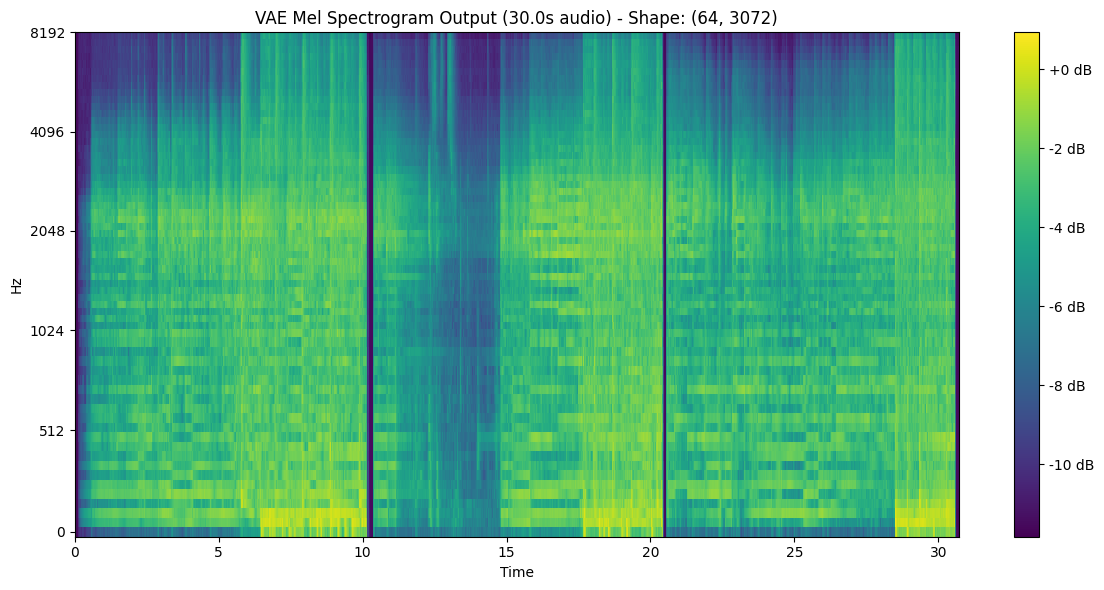

Mel stats - Min: -11.842, Max: 0.933, Mean: -4.405, Std: 2.351


In [9]:
# VAE DECODER - Using standard approach for now (will optimize later)
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run VAE
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = model.decode_first_stage(samples)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"VAE DECODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VAE DECODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VAE TIME: {vae_time:.1f}s")

# 🔍 VAE DECODER OUTPUT ANALYSIS & VISUALIZATION
print(f"\n🔍 VAE DECODER OUTPUT ANALYSIS:")
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")
print(f"Latent → Mel conversion factor: {mel_spectrogram.shape[2] / samples.shape[2]:.2f}x")
print(f"Mel frames: {mel_spectrogram.shape[2]}")
print(f"Expected mel duration: {mel_spectrogram.shape[2] / 62.5:.2f}s")  # Typical AudioLDM mel rate
check_for_nan_inf(mel_spectrogram, "VAE mel spectrogram output")

# Display mel spectrogram
print(f"\n📊 MEL SPECTROGRAM (from VAE Decoder):")
plot_mel_spectrogram(mel_spectrogram, f"VAE Mel Spectrogram Output ({duration}s audio)", sr=sr)

In [10]:
# VOCODER - Using standard approach for now (will optimize later)
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)[0]
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

print(f"\nFINAL RESULTS:")
print(f"Generated {duration}s audio with Naive Chunking")
print(f"Audio shape: {waveform.shape}")
print(f"Audio duration (samples): {len(waveform) / sr:.1f}s")
print(f"Expected samples for {duration}s: {int(duration * sr)}")
print(f"Actual samples: {len(waveform)}")
print(f"Duration discrepancy: {(len(waveform) / sr) - duration:.3f}s")
print(f"Mel → Audio conversion factor: {len(waveform) / mel_spectrogram.shape[2]:.1f}x")
print(f"Overall latent → audio factor: {len(waveform) / samples.shape[2]:.1f}x")

ipd.display(ipd.Audio(waveform, rate=sr))
print(torch.cuda.memory_summary())

VOCODER ISOLATED PEAK: 4808.7 MiB (cost: +362.8 MiB)
VOCODER CURRENT MEMORY: 4445.9 MiB
VOCODER TIME: 0.2s

FINAL RESULTS:
Generated 30.0s audio with Naive Chunking
Audio shape: (1, 491552)
Audio duration (samples): 0.0s
Expected samples for 30.0s: 480000
Actual samples: 1
Duration discrepancy: -30.000s
Mel → Audio conversion factor: 0.0x
Overall latent → audio factor: 0.0x


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4445 MiB |   4808 MiB |   3709 GiB |   3705 GiB |
|       from large pool |   4316 MiB |   4679 MiB |   3560 GiB |   3556 GiB |
|       from small pool |    129 MiB |    129 MiB |    149 GiB |    149 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4445 MiB |   4808 MiB |   3709 GiB |   3705 GiB |
|       from large pool |   4316 MiB |   4679 MiB |   3560 GiB |

In [11]:
import soundfile as sf

# Ensure waveform is a NumPy array and has the correct shape
waveform = waveform.squeeze()  # Remove batch dimension if present
if isinstance(waveform, torch.Tensor):
    waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# Save the generated audio to a file
output_path = "../output/generation"
os.makedirs(output_path, exist_ok=True)
filename = f"naive.wav"  # Simplify filename
sf.write(os.path.join(output_path, filename), waveform, sr)

print(f"Audio saved to {os.path.join(output_path, filename)}")

# Random edit
print("Random notebook edit executed!")

Audio saved to ../output/generation/naive.wav
Random notebook edit executed!
